# r/feminism experiment analysis
J. Nathan Matias, June, 2020

The [pre-analysis plan](https://osf.io/b42q6/)  for this study is on the Open Science Framework.

## Codebook
#### Study Participation
* **message.sent**: Was the intervention sent to the account? (true) or had it been entirely banned by reddit by the point at which we attempted to send the intervention (false)
* **complied**: Did the account complete the survey?
* **treatment**: Did the account receive the intervention? (0/1)
* **block_id**: What randomization block was the account in?

#### Comments
* **comments_n_weeks**:: The number of comments made by the account over N weeks

#### Bans
* **ban_days_N_weeks**: The number of days the account was banned from posting in the subreddit over N weeks

#### Post-Survey Responses
* **ingroup**: Did the account report identifying as a feminist when they first commented in the community?
* **inclusion**: The reported closeness to the r/feminism community on a scale of 1 to 7


## Frontmatter
### Load Libraries

In [82]:
library(MASS)
library(ggplot2)
library(gmodels) #contains CrossTable
library(ri2)
library(estimatr)
library(ggpubr)   # contains ggarrange
library(png)      # to load logo
library(grid)
library(stringr)

options(repr.plot.width=7, repr.plot.height=3)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] stringr_1.3.1    png_0.1-7        ggpubr_0.2.5     magrittr_1.5    
 [5] ri2_0.1.2        estimatr_0.14    randomizr_0.16.1 gmodels_2.18.1  
 [9] ggplot2_3.1.0    MASS_7.3-51.1    jsonlite_1.6.1  

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.0       pillar_1.4.4     compiler_3.5.1   plyr_1.8.4      
 [5] base64enc_0.1-3  tools_3.5.1      digest_0.6.25    uuid_0.1-2      
 [9] evaluate_0.13    lifecycle_0.2.0  tibble_3.0.1     gtable_0.2.0    
[13] texreg_1.36.23   pkg

### Set Visual Style

In [2]:
## Set visual style
catpalette   <- c("#333333", "#ea5324", "#005073", "#7D868C", "#BDBBBB", "#F2F2F2","#F6F2EB")
chartpalette <- c("#ea5324", "#005073", "#7D868C", "#333333", "#F2F2F2","#BDBBBB", "#F6F2EB")

bg.whiteortransparent <- "transparent" #Sys.getenv('RTRANSPARENTBG','white')


translation_lang="english"

cat.theme <-  theme_bw() +
              theme(plot.title = element_text(size=13, face="bold", color=catpalette[3]),
                    axis.title.x =element_text(size=10, hjust = -0.01, color = catpalette[1]),
                    axis.title.y =element_text(size=10, color = catpalette[1]),
                    panel.background = element_rect(fill=catpalette[6]),
                    plot.background = element_rect(fill =bg.whiteortransparent, color = NA), # bg of the plot
                   )

blog.img.path <- "../assets"
cat.logo.filename <- "../assets/CAT-Logo-Horizontal-social-media-preview-color.png"
logo.img <- readPNG(cat.logo.filename)
logo.pngob <- rasterGrob(logo.img)

h.just <- ifelse(translation_lang %in% c('arabic', 'persian'), 1, 0)
x.just <- ifelse(translation_lang %in% c('arabic', 'persian'), 0.98, 0)

### Load Data

In [3]:
## Load 2018 survey
participants.2018 <- read.csv("../data/merged_survey_responses-04.18.2018-07.52-ET.csv")
participants.2018$comments <- NA

In [4]:
## NOTE: THE SOFTWARE CONTINUED TO ASSIGN PARTICIPANTS EVEN AFTER
## THE EXPERIMENT INTERVENTIONS WERE HALTED, AS CONFIRMED FROM REDDIT ARCHIVES
## FOR THIS REASON, WE REMOVE ALL PARTICIPANTS ASSIGNED AFTER TREATMENT CONCLUDED
#r-feminism-study-data-merged-06.14.2020.csv
accounts <- read.csv("../data/r-feminism-study-data-merged-06.19.2020.csv",
                          stringsAsFactors = FALSE)

accounts$counter <-1
c.df <- aggregate(accounts[c("counter")], by=list(accounts$block_id), FUN=sum)

## remove extraneous block 0001 entries due to a software error
block0001.df <- subset(accounts,block_id=="block0001")
extraneous.ids <- block0001.df[order(block0001.df$assignment_datetime),]$id[11:length(block0001.df)]
print(paste(length(extraneous.ids), "rows removed due to a software error in block0001"))
accounts <- subset(accounts, (id %in% extraneous.ids)!=TRUE)

final.treat.time <- as.POSIXlt('2020-04-18 23:38:11')
accounts$after.treat.date <- accounts$assignment_datetime >= final.treat.time

newcomers <- subset(accounts, after.treat.date!=TRUE) 

## remove blocks with missing observations
balance.check.df <- aggregate(newcomers[c("treatment")], by=list(newcomers$block_id), FUN=mean)
imbalanced.blocks <- subset(balance.check.df, treatment!=0.5)$Group
print(paste(length(imbalanced.blocks), "blocks removed for problems:", toString(imbalanced.blocks)))

newcomers <- subset(newcomers, (block_id %in% imbalanced.blocks)!=TRUE)

newcomers$complied = newcomers$completed_survey=="True"
newcomers$message.sent = newcomers$message_status == "sent" & newcomers$treatment==1
newcomers$num.comments <- newcomers$comments_2_weeks
newcomers$TREAT <- newcomers$treatment
newcomers$banned.days <- newcomers$ban_days_2_weeks

newcomers$ingroup <- NA
newcomers[newcomers$complied,]$ingroup <- newcomers[newcomers$complied,]$identify_feminist=="Yes"

newcomers$ingroup <- factor(newcomers$ingroup, levels=c(FALSE, TRUE),labels=c("Not Feminist", "Feminist"))


newcomers$inclusion <- NA
newcomers[newcomers$complied,]$inclusion <- newcomers[newcomers$complied,]$community_closeness

[1] "37 rows removed due to a software error in block0001"
[1] "3 blocks removed for problems: block0077, block0085, block0097"


# Summary Statistics

In [5]:
nrow(newcomers)

[1] 1300

In [6]:
first.date <- min(as.Date(newcomers$assignment_datetime))
last.date <- max(as.Date(newcomers$assignment_datetime))

newcomers$assignment.week <- as.integer(difftime(as.Date(newcomers$assignment_datetime),  first.date, units="weeks"))

summary(newcomers$after.treat.date)

   Mode   FALSE 
logical    1300 

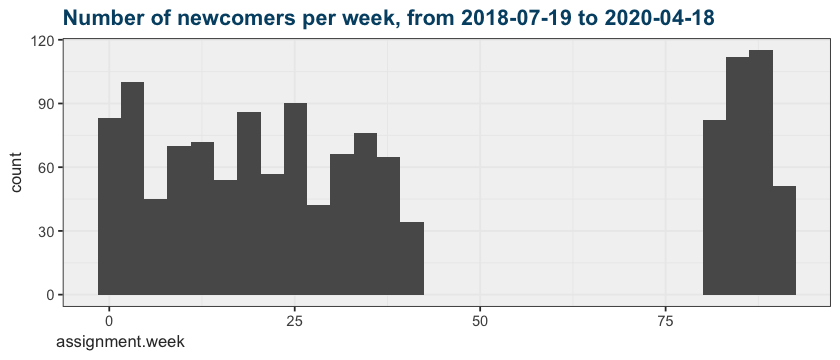

In [7]:
ggplot(newcomers, aes(assignment.week)) +
    geom_histogram(bins=30) +
    cat.theme +
    ggtitle(paste("Number of newcomers per week, from", first.date, "to", last.date))

In [8]:
nrow(newcomers)
nrow(subset(newcomers, message.sent))
nrow(subset(newcomers, complied))

[1] 1300

[1] 587

[1] 320

In [9]:
summary(factor(newcomers$treatment))

0   1 
650 650

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   2.225   2.000  55.000 

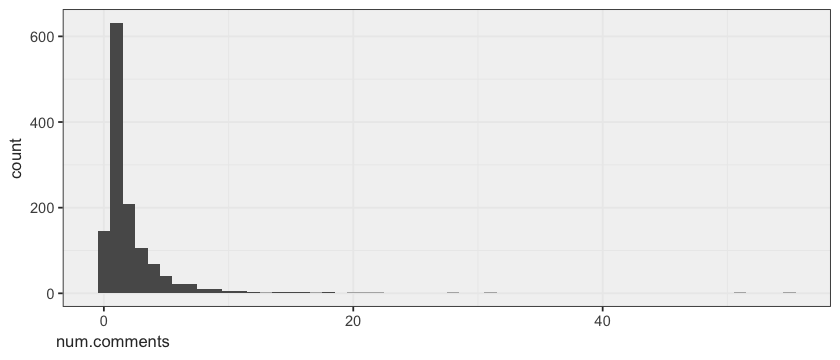

In [10]:
summary(newcomers$num.comments)
ggplot(newcomers, aes(num.comments)) +
    geom_histogram(binwidth=1) +
    cat.theme

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   4.000   4.166   6.000   7.000 

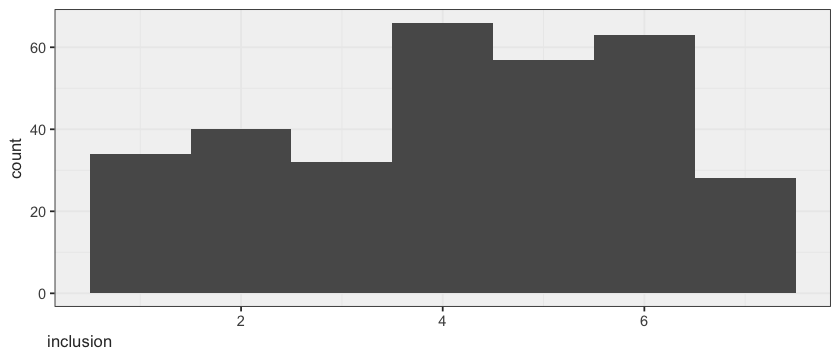

In [11]:
summary(subset(newcomers, complied)$inclusion)
ggplot(subset(newcomers, complied), aes(inclusion)) +
    geom_histogram(binwidth=1) +
    cat.theme

In [13]:
## look at ban rates for ingroup and outgroup
CrossTable(newcomers$banned.days>0, newcomers$ingroup, prop.chisq = FALSE, prop.t = FALSE)


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  320 

 
                          | newcomers$ingroup 
newcomers$banned.days > 0 | Not Feminist |     Feminist |    Row Total | 
--------------------------|--------------|--------------|--------------|
                    FALSE |           47 |          214 |          261 | 
                          |        0.180 |        0.820 |        0.816 | 
                          |        0.603 |        0.884 |              | 
--------------------------|--------------|--------------|--------------|
                     TRUE |           31 |           28 |           59 | 
                          |        0.525 |        0.475 |        0.184 | 
                          |        0.397 |        0.116 |              | 
--------------------------|--------------|--------------|--------------|
             Co

In [20]:
summary(newcomers$banned.days>0)

   Mode   FALSE    TRUE 
logical    1101     199 

In [21]:
summary(factor(subset(newcomers, complied)$identify_feminist))
summary(newcomers$ingroup)

No Undecided       Yes 
       51        27       242

Not Feminist     Feminist         NA's 
          78          242          980

# Questions about Balance in the Sample

In [22]:
## How can we make sense of the message_status field, which should
## indicate that the account never received the intervention?
summary(factor(newcomers$message.sent))
CrossTable(newcomers$message.sent, newcomers$treatment, prop.chisq = FALSE, prop.t = FALSE)

FALSE  TRUE 
  713   587


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1300 

 
                       | newcomers$treatment 
newcomers$message.sent |         0 |         1 | Row Total | 
-----------------------|-----------|-----------|-----------|
                 FALSE |       650 |        63 |       713 | 
                       |     0.912 |     0.088 |     0.548 | 
                       |     1.000 |     0.097 |           | 
-----------------------|-----------|-----------|-----------|
                  TRUE |         0 |       587 |       587 | 
                       |     0.000 |     1.000 |     0.452 | 
                       |     0.000 |     0.903 |           | 
-----------------------|-----------|-----------|-----------|
          Column Total |       650 |       650 |      1300 | 
                       |     0.500 |     0.500 |           | 
-----------

In [23]:
## What is the balance among survey compliers 
## and among accounts that identified as feminist
summary(newcomers$complied)
CrossTable(newcomers$complied, newcomers$treatment, prop.chisq = FALSE, prop.t = FALSE)
CrossTable(subset(newcomers, complied)$identify_feminist, subset(newcomers, complied)$treatment, prop.chisq = FALSE, prop.t = FALSE)

   Mode   FALSE    TRUE 
logical     980     320 


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1300 

 
                   | newcomers$treatment 
newcomers$complied |         0 |         1 | Row Total | 
-------------------|-----------|-----------|-----------|
             FALSE |       487 |       493 |       980 | 
                   |     0.497 |     0.503 |     0.754 | 
                   |     0.749 |     0.758 |           | 
-------------------|-----------|-----------|-----------|
              TRUE |       163 |       157 |       320 | 
                   |     0.509 |     0.491 |     0.246 | 
                   |     0.251 |     0.242 |           | 
-------------------|-----------|-----------|-----------|
      Column Total |       650 |       650 |      1300 | 
                   |     0.500 |     0.500 |           | 
-------------------|-----------|-----------|-----------|

 

 


# Bivariate Analysis

### Feminist and Closeness to Community

In [86]:
aggregate(FUN="mean", subset(newcomers, complied)[c("inclusion")], 
          by=list(subset(newcomers, complied)$ingroup))

Group.1,inclusion
Not Feminist,2.576923
Feminist,4.677686


# Analyze Results

### Results Tables

In [31]:
survey.compliers <- subset(newcomers, complied)
aggregate(survey.compliers[c("inclusion")], by=list(survey.compliers$treatment), FUN=mean)

Group.1,inclusion
0,4.122699
1,4.210191


In [29]:
aggregate(newcomers[c("comments_2_weeks","comments_3_weeks","comments_4_weeks",
                      "comments_5_weeks","comments_6_weeks","comments_7_weeks",
                      "comments_8_weeks","comments_9_weeks","comments_10_weeks",
                      "complied")],
          by=list(newcomers$treatment),
          FUN=mean)

Group.1,comments_2_weeks,comments_3_weeks,comments_4_weeks,comments_5_weeks,comments_6_weeks,comments_7_weeks,comments_8_weeks,comments_9_weeks,comments_10_weeks,complied
0,2.016923,2.129231,2.215385,2.273846,2.346154,2.433846,2.476923,2.521538,2.555385,0.2507692
1,2.433846,2.553846,2.629231,2.689231,2.766154,2.824615,2.869231,2.932308,2.967692,0.2415385


### Statistical Tests

In [32]:
## set up instrument
iv <- lm(message.sent ~ treatment, data=newcomers)
newcomers$iv <- predict(iv, newcomers)


## two weeks (pre-registered)
m2 <- glm.nb(num.comments ~ treatment, data = newcomers)
comments.2.m <- glm.nb(num.comments ~ iv, data=newcomers)

## three weeks
m3 <- glm.nb(comments_3_weeks ~ treatment, data = newcomers)
comments.3.m <- glm.nb(comments_3_weeks ~ iv, data=newcomers)

## four weeks
m4 <- glm.nb(comments_4_weeks ~ treatment, data = newcomers)
comments.4.m <- glm.nb(comments_4_weeks ~ iv, data=newcomers)

## five weeks
m5 <- glm.nb(comments_5_weeks ~ treatment, data = newcomers)
comments.5.m <- glm.nb(comments_5_weeks ~ iv, data=newcomers)

## six weeks
m6 <- glm.nb(comments_6_weeks ~ treatment, data = newcomers)
comments.6.m <- glm.nb(comments_6_weeks ~ iv, data=newcomers)

## seven weeks
m7 <- glm.nb(comments_7_weeks ~ treatment, data = newcomers)
comments.7.m <- glm.nb(comments_7_weeks ~ iv, data=newcomers)

## eight weeks
m8 <- glm.nb(comments_8_weeks ~ treatment, data = newcomers)
comments.8.m <- glm.nb(comments_8_weeks ~ iv, data=newcomers)

## nine weeks
m9 <- glm.nb(comments_9_weeks ~ treatment, data = newcomers)
comments.9.m <- glm.nb(comments_9_weeks ~ iv, data=newcomers)

## ten weeks
m10 <- glm.nb(comments_10_weeks ~ treatment, data = newcomers)
comments.10.m <- glm.nb(comments_10_weeks ~ iv, data=newcomers)

summary(comments.2.m)


Call:
glm.nb(formula = num.comments ~ iv, data = newcomers, init.theta = 1.612639585, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7226  -0.7121  -0.5610  -0.0080   6.6508  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.70157    0.04143  16.932  < 2e-16 ***
iv           0.20807    0.06364   3.269  0.00108 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.6126) family taken to be 1)

    Null deviance: 1261.8  on 1299  degrees of freedom
Residual deviance: 1251.1  on 1298  degrees of freedom
AIC: 5126.9

Number of Fisher Scoring iterations: 1


              Theta:  1.613 
          Std. Err.:  0.101 

 2 x log-likelihood:  -5120.943 

# Inclusion of the Group in the Self Scale

In [41]:
summary(i1.prereg <- lm(inclusion ~ treatment, data= subset(newcomers, complied)))


Call:
lm(formula = inclusion ~ treatment, data = subset(newcomers, 
    complied))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2102 -1.2102 -0.1227  1.7898  2.8773 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.12270    0.14230  28.972   <2e-16 ***
treatment    0.08749    0.20316   0.431    0.667    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.817 on 318 degrees of freedom
Multiple R-squared:  0.0005829,	Adjusted R-squared:  -0.00256 
F-statistic: 0.1855 on 1 and 318 DF,  p-value: 0.667


In [68]:
summary(i1 <- lm(inclusion ~ treatment + ingroup + ingroup:treatment, data= subset(newcomers, complied)))


Call:
lm(formula = inclusion ~ treatment + ingroup + ingroup:treatment, 
    data = subset(newcomers, complied))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7787 -1.0270  0.2213  1.2213  4.8293 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 2.1707     0.2443   8.886  < 2e-16 ***
treatment                   0.8563     0.3547   2.414  0.01633 *  
ingroupFeminist             2.6080     0.2824   9.236  < 2e-16 ***
treatment:ingroupFeminist  -1.0600     0.4077  -2.600  0.00977 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.564 on 316 degrees of freedom
Multiple R-squared:  0.2638,	Adjusted R-squared:  0.2569 
F-statistic: 37.75 on 3 and 316 DF,  p-value: < 2.2e-16


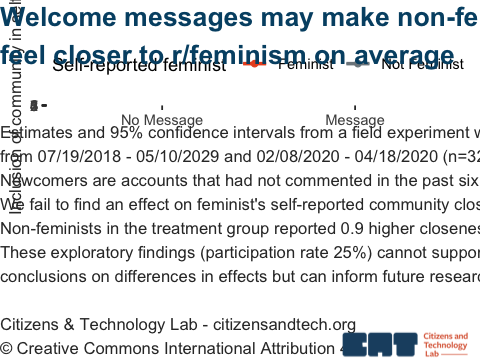

In [72]:
options(repr.plot.width=4, repr.plot.height=3)


inclusion.plot.title <- paste("Welcome messages may make non-feminists\nfeel closer to r/feminism on average")

inclusion.plot.caption <- paste("Estimates and 95% confidence intervals from a field experiment with r/feminism\n", 
                                "from 07/19/2018 - 05/10/2029",
                                " and 02/08/2020 - 04/18/2020", " (n=", nrow(subset(newcomers, complied)), " surveys).\n",
                               "Newcomers are accounts that had not commented in the past six months.\n",
                               "We fail to find an effect on feminist's self-reported community closeness.\n",
                               "Non-feminists in the treatment group reported 0.9 higher closeness (p=0.016)\n",
                               "These exploratory findings (participation rate ",prettyNum(nrow(subset(newcomers,complied)) / nrow(newcomers)*100, digits=2) ,"%) ",
                               "cannot support strong\n",
                               "conclusions on differences ",
                               "in effects but can inform future research design.",
                                "\n\n",
                               "Citizens & Technology Lab - citizensandtech.org\n",
                               "© Creative Commons International Attribution 4.0",
                               sep="")


inclusion.df <- data.frame(treatment=c(0,0,1,1), ingroup=c("Feminist", "Not Feminist", "Feminist", "Not Feminist"))
inclusion.df <- cbind(inclusion.df, predict(i1, inclusion.df, interval="confidence"))

inclusion.plot <- 
    ggplot(inclusion.df, aes(treatment, fit, color=ingroup)) +
    geom_point() +
    geom_line() + 
    geom_errorbar(aes(ymax=upr, ymin=lwr), 
                  size=1, width=0.05) +
    scale_x_continuous(breaks=c(0,1), limits=c(-0.5, 1.5), 
                       labels=c("No Message", "Message")) +
    scale_y_continuous(breaks=c(1,2,3,4,5,6,7), limits=c(1,7)) +
    scale_color_manual(values=c(catpalette[2], catpalette[4]), 
                       name="Self-reported feminist") +
    ylab("Inclusion of community in self") +
    xlab("") +
    cat.theme +
    theme(legend.background=element_rect(fill=bg.whiteortransparent),
          legend.key=element_rect(fill=bg.whiteortransparent),
          legend.position="top")


## ADD HEADER/FOOTER AND WRITE TO FILE
inclusion.plot <- annotate_figure(inclusion.plot,
                        top=text_grob(inclusion.plot.title,
                                      hjust=h.just, x=x.just, size=16,
                                      face="bold",
                                      color=chartpalette[2]),
                        bottom=text_grob(inclusion.plot.caption, 
                                         hjust=h.just, x=x.just, size=10, 
                                         color=chartpalette[4])) +
                  annotation_custom(logo.pngob, ymin=-0.92, xmin=0.7-(0.7*h.just), xmax=1-(0.7*h.just)) +
                    ggsave(file.path(blog.img.path, str_interp('inclusion-plot-${bg.whiteortransparent}-${translation_lang}.png')),
                          width=5, height=6.5 , units='in', bg=bg.whiteortransparent)

inclusion.plot

In [38]:
p.values <- data.frame(model=c("comments", "inclusion"),
                       value= p.adjust(c(
                           coef(summary(m2))['treatment',][['Pr(>|z|)']], 
                           coef(summary(i1))['treatment',][['Pr(>|t|)']]), method="hochberg"))
p.values

model,value
comments,0.002154899
inclusion,0.016334439


# Generate Charts

In [44]:
coef(summary(m2))
confint(m2)
m2$df.residual

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),0.7015731,0.04143403,16.932294,2.600456e-64
treatment,0.1878997,0.05747079,3.269481,1.077450e-03


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),0.62047531,0.7829162
treatment,0.07528631,0.3005838


[1] 1298

In [45]:
model.estimates <- function(model, model.name, week, n.size, treatment.pvalue = NULL){

    results       <- data.frame(cbind(coef(summary(model)), confint(model)))
    results$model <- model.name
    results$coef <- row.names(results)
    names(results)[4] <- "pvalue"
    names(results)[5] <- "CI.Lower"
    names(results)[6] <- "CI.Upper"
    results$DF       <- model$df.residual
    results$n.size   <- n.size
    results$week = week
    results
}

In [46]:
## initial comment result
comment.results <- model.estimates(m2, "2 week comments", 2, nrow(newcomers), treatment.pvalue = subset(p.values, model=="comments")[['value']])
## add adjusted pvalue
comment.results[comment.results$coef=="treatment",]$pvalue <- subset(p.values, model=="comments")[['value']]

Waiting for profiling to be done...


In [47]:
week = 3
comment.models <- comment.results
comment.models$week = 2
for(model in list(m3,m4,m5,m6,m7,m8,m9,m10)){
    comment.label <- paste(week, "week comments")
    comment.models <- rbind(comment.models, model.estimates(model, comment.label, week, nrow(newcomers)))
    week = week + 1
}

Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...


In [48]:
comment.models

,Estimate,Std..Error,z.value,pvalue,CI.Lower,CI.Upper,model,coef,DF,n.size,week
(Intercept),0.7015731,0.04143403,16.932294,2.600456e-64,0.62047531,0.7829162,2 week comments,(Intercept),1298,1300,2
treatment,0.1878997,0.05747079,3.269481,2.154899e-03,0.07528631,0.3005838,2 week comments,treatment,1298,1300,2
(Intercept)1,0.7557608,0.04148555,18.217445,3.752752e-74,0.67461623,0.8372593,3 week comments,(Intercept),1298,1300,3
treatment1,0.1818397,0.05763652,3.154940,1.605313e-03,0.06889646,0.2948445,3 week comments,treatment,1298,1300,3
(Intercept)2,0.7954260,0.04166909,19.089115,3.109918e-81,0.71396739,0.8773303,4 week comments,(Intercept),1298,1300,4
treatment2,0.1712653,0.05799413,2.953149,3.145503e-03,0.05761652,0.2849674,4 week comments,treatment,1298,1300,4
(Intercept)3,0.8214727,0.04190035,19.605389,1.390860e-85,0.73959589,0.9038658,5 week comments,(Intercept),1298,1300,5
treatment3,0.1677825,0.05836756,2.874584,4.045600e-03,0.05339917,0.2822149,5 week comments,treatment,1298,1300,5
(Intercept)4,0.8527773,0.04230505,20.157812,2.298212e-90,0.77015547,0.9360126,6 week comments,(Intercept),1298,1300,6
treatment4,0.1646805,0.05899043,2.791648,5.244035e-03,0.04907329,0.2803322,6 week comments,treatment,1298,1300,6


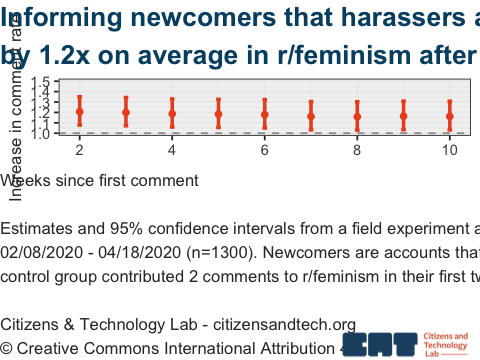

In [50]:
comments.plot.title <- paste("Informing newcomers that harassers are a minority increased newcomer comments\n",
                  "by ", prettyNum(exp(subset(comment.results, coef=="treatment")[['Estimate']]), digits=2), 
                  "x ", 
                  "on average in r/feminism after two weeks, an effect that persisted over time", sep="")

comments.plot.caption <- paste("Weeks since first comment\n\n", 
                               "Estimates and 95% confidence intervals from a field experiment among newcomers to r/feminism ",
                               "from ", "07/19/2018 - 05/10/2029 and",
                               "\n02/08/2020 - 04/18/2020", " (n=", nrow(newcomers), "). ",
                               "Newcomers are accounts that had not commented in the past six months. ",
                               "On average, newcomers in the\n",
                               "control group contributed ", prettyNum(mean(subset(newcomers, treatment==0)$num.comments), digits=2),
                               " comments to r/feminism in their first two weeks. ",
                               "Estimates are incidence rate ratios from a negative binomial model.",
                               "\n\n",
                               "Citizens & Technology Lab - citizensandtech.org\n",
                               "© Creative Commons International Attribution 4.0",
                               sep="")


df <- subset(comment.models, coef=="treatment")

comments.plot <- 
    ggplot(df, aes(week, exp(Estimate))) +
    geom_errorbar(aes(ymax=exp(df$CI.Upper), ymin=exp(df$CI.Lower)), 
                  size=1, color=chartpalette[1], width=0.1) +
    geom_point(color=chartpalette[1]) +
    geom_hline(yintercept = 1, linetype="dashed", color="#999999") +
    ylim(1,1.5) +
    ylab("Increase in comment rate") +
    cat.theme +
    theme(axis.title.x = element_blank()) 

## ADD HEADER/FOOTER AND WRITE TO FILE
comments.plot <- annotate_figure(comments.plot,
                        top=text_grob(comments.plot.title,
                                      hjust=h.just, x=x.just, size=16,
                                      face="bold",
                                      color=chartpalette[2]),
                        bottom=text_grob(comments.plot.caption, 
                                         hjust=h.just, x=x.just, size=10, 
                                         color=chartpalette[4])) +
                  annotation_custom(logo.pngob, ymin=-0.92, xmin=0.7-(0.7*h.just), xmax=1-(0.7*h.just)) +
                    ggsave(file.path(blog.img.path, str_interp('comments-plot-${bg.whiteortransparent}-${translation_lang}.png')),
                          width=9, height=5.67 , units='in', bg=bg.whiteortransparent)
comments.plot

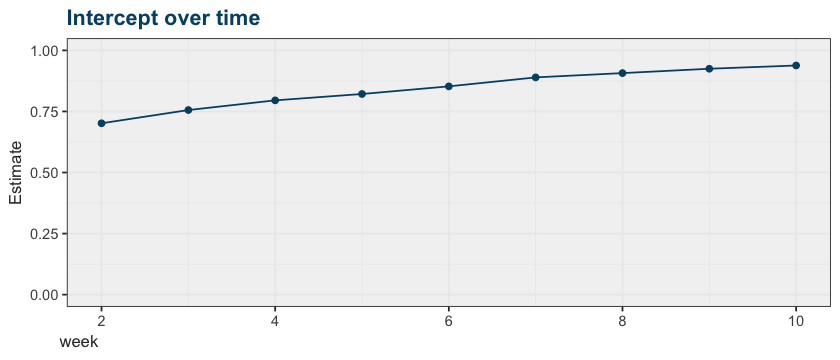

In [54]:
options(repr.plot.width=7, repr.plot.height=3)

df <- subset(comment.models, coef=="(Intercept)")
ggplot(df, aes(week, Estimate)) +
    geom_line(color=chartpalette[2]) +
    geom_point(color=chartpalette[2]) +
    ylim(0,1) +
    cat.theme +
    ggtitle("Intercept over time")

# Attitudes and Behaviors

### 2018 survey

In [62]:
participants.2018$complied == participants.2018$took.survey
participants.2018$ingroup <- participants.2018$feminist=="Yes"
participants.2018$inclusion <- participants.2018$r.feminism.relationship
surveys.2018 <- subset(participants.2018, took.survey)
surveys.2018$ingroup <- factor(surveys.2018$ingroup, levels=c(FALSE, TRUE),labels=c("Not Feminist", "Feminist"))

surveys.2018$is.feminist <- factor(surveys.2018$feminist, levels=c("No", "Undecided", "Yes"),labels=c("Not Feminist", "Undecided", "Feminist"))


paste("Response rate: ",prettyNum((nrow(subset(surveys.2018, took.survey)) / nrow(participants.2018))*100, digits=2), "%", sep="")

ctl.survey.compliers$is.feminist <- factor(ctl.survey.compliers$identify_feminist, levels=c("No", "Undecided", "Yes"),labels=c("Not Feminist", "Undecided", "Feminist"))

logical(0)

[1] "Response rate: 30%"

### Do commenters who identified as feminists comment more? No; non-feminists comment more

In [61]:
ctl.survey.compliers <- subset(newcomers,complied & treatment==0)
surveys.2018$ingroup <- factor(surveys.2018$ingroup, levels=c(FALSE, TRUE),labels=c("Not Feminist", "Feminist"))

ctl.response.rate <- nrow(ctl.survey.compliers) / nrow(subset(newcomers, treatment==0))
nrow(ctl.survey.compliers)
ctl.response.rate
summary(glm.nb(num.comments ~ ingroup, data=ctl.survey.compliers))

[1] 163

[1] 0.2507692


Call:
glm.nb(formula = num.comments ~ ingroup, data = ctl.survey.compliers, 
    init.theta = 2.401651755, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8981  -0.5605  -0.5605   0.0526   4.1733  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.9869     0.1387   7.114 1.13e-12 ***
ingroupFeminist  -0.3442     0.1642  -2.096   0.0361 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(2.4017) family taken to be 1)

    Null deviance: 154.43  on 162  degrees of freedom
Residual deviance: 150.02  on 161  degrees of freedom
AIC: 617.3

Number of Fisher Scoring iterations: 1


              Theta:  2.402 
          Std. Err.:  0.510 

 2 x log-likelihood:  -611.301 

### 2018 Survey

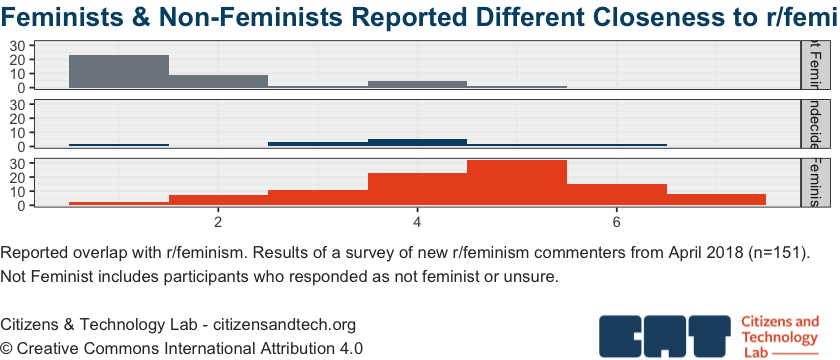

In [88]:
closeness.plot.title   <- "Feminists & Non-Feminists Reported Different Closeness to r/feminism"
closeness.plot.caption <- paste("Reported overlap with r/feminism. ",
         "Results of a survey of new r/feminism commenters from April 2018 (n=", nrow(surveys.2018),").\n",
         "Not Feminist includes participants who responded as not feminist or unsure.",
         "\n\n",
         "Citizens & Technology Lab - citizensandtech.org\n",
         "© Creative Commons International Attribution 4.0",
         sep="")

closeness.plot <- ggplot(subset(surveys.2018), aes(inclusion, fill=factor(is.feminist))) +
    geom_histogram(binwidth=1) +
    facet_grid(is.feminist ~ .) +
    scale_fill_manual(values=c(catpalette[4], catpalette[3], catpalette[2]), guide=FALSE) +
    cat.theme +
    theme(axis.title.x = element_blank(),
          axis.title.y = element_blank()) 

## ADD HEADER/FOOTER AND WRITE TO FILE
closeness.plot <- annotate_figure(closeness.plot,
                    top=text_grob(closeness.plot.title,
                                  hjust=h.just, x=x.just, size=16,
                                  face="bold",
                                  color=chartpalette[2]),
                    bottom=text_grob(closeness.plot.caption, 
                                     hjust=h.just, x=x.just, size=10, 
                                     color=chartpalette[4])) +
                    annotation_custom(logo.pngob, ymin=-0.88, xmin=0.7-(0.7*h.just), xmax=1-(0.7*h.just)) +
                    ggsave(file.path(blog.img.path, str_interp('closeness-plot-${bg.whiteortransparent}-${translation_lang}.png')),
                          width=7.5, height=4 , units='in', bg=bg.whiteortransparent)
closeness.plot

# Effect on Num Comments Removed and on Chance of Receiving a Ban

In [64]:
summary(glm.nb(removed_comments_10_weeks ~ treatment, data=newcomers))
summary(lm(as.integer(ban_days_8_weeks>0) ~ treatment, data=newcomers))


Call:
glm.nb(formula = removed_comments_10_weeks ~ treatment, data = newcomers, 
    init.theta = 0.04905449503, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5549  -0.5549  -0.5514  -0.5514   1.8736  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.07981    0.18106   0.441    0.659
treatment   -0.04207    0.25618  -0.164    0.870

(Dispersion parameter for Negative Binomial(0.0491) family taken to be 1)

    Null deviance: 421.69  on 1299  degrees of freedom
Residual deviance: 421.67  on 1298  degrees of freedom
AIC: 2182.3

Number of Fisher Scoring iterations: 1


              Theta:  0.04905 
          Std. Err.:  0.00447 

 2 x log-likelihood:  -2176.33200 


Call:
lm(formula = as.integer(ban_days_8_weeks > 0) ~ treatment, data = newcomers)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1938 -0.1938 -0.1723 -0.1723  0.8277 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.17231    0.01517  11.355   <2e-16 ***
treatment    0.02154    0.02146   1.004    0.316    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3869 on 1298 degrees of freedom
Multiple R-squared:  0.0007755,	Adjusted R-squared:  5.633e-06 
F-statistic: 1.007 on 1 and 1298 DF,  p-value: 0.3157


# Estimating the effect on number of comments as pre-registered
The pre-registered analysis plan specified the number of days an account was banned as an important adjustment variable. While the results are very similar, we dropped it from the final analysis since it's a post-treatment variable, something we should have avoided in the pre-analysis plan. Here's the result we pre-registered. As you can see, it is very close to the main finding we report.

In [65]:
summary(glm.nb(num.comments ~ treatment + ban_days_8_weeks, data=newcomers))


Call:
glm.nb(formula = num.comments ~ treatment + ban_days_8_weeks, 
    data = newcomers, init.theta = 1.701283677, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9914  -0.6387  -0.5018   0.0700   7.1134  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      0.620204   0.042733  14.513  < 2e-16 ***
treatment        0.167271   0.056876   2.941  0.00327 ** 
ban_days_8_weeks 0.009566   0.001431   6.685  2.3e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.7013) family taken to be 1)

    Null deviance: 1298.3  on 1299  degrees of freedom
Residual deviance: 1242.0  on 1297  degrees of freedom
AIC: 5084.4

Number of Fisher Scoring iterations: 1


              Theta:  1.701 
          Std. Err.:  0.109 

 2 x log-likelihood:  -5076.353 

# Sub-group analysis on number of comments between feminists and non-feminists

In [80]:
summary(glm.nb(num.comments ~ treatment, data=subset(newcomers, complied & ingroup=="Feminist")))


Call:
glm.nb(formula = num.comments ~ treatment, data = subset(newcomers, 
    complied & ingroup == "Feminist"), init.theta = 1.537360367, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8101  -0.8476  -0.5075   0.0471   3.8534  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.64272    0.09819   6.545 5.93e-11 ***
treatment    0.43058    0.13383   3.217  0.00129 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.5374) family taken to be 1)

    Null deviance: 244.26  on 241  degrees of freedom
Residual deviance: 233.88  on 240  degrees of freedom
AIC: 986.41

Number of Fisher Scoring iterations: 1


              Theta:  1.537 
          Std. Err.:  0.214 

 2 x log-likelihood:  -980.410 

In [81]:
summary(glm.nb(num.comments ~ treatment, data=subset(newcomers, complied & ingroup=="Not Feminist")))


Call:
glm.nb(formula = num.comments ~ treatment, data = subset(newcomers, 
    complied & ingroup == "Not Feminist"), init.theta = 2.945949342, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9532  -0.9077  -0.3231   0.4308   2.9845  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.98691    0.13180   7.488 6.98e-14 ***
treatment   -0.01286    0.19170  -0.067    0.947    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(2.9459) family taken to be 1)

    Null deviance: 76.347  on 77  degrees of freedom
Residual deviance: 76.343  on 76  degrees of freedom
AIC: 325.98

Number of Fisher Scoring iterations: 1


              Theta:  2.946 
          Std. Err.:  0.943 

 2 x log-likelihood:  -319.978 

# COPYRIGHT

Copyright 2020 Cornell University

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.